In [32]:
import __init__
import os
import numpy as np
import pandas as pd
import yaml
import shap
import datetime
from tqdm import tqdm
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from datapath_manager import DataPathManager, ITWDataPathManager
from trainers import MachineLearningModelTrainer, BranchNeuralNetworkTrainer
from dataloader import EmbeddingDataLoader
from evaluators import Evaluator
from statsmodels.stats.outliers_influence import variance_inflation_factor
import json

In [33]:
user_id = 'ltkhiem'
dates = ['2022-10-16', '2022-10-17', '2022-10-18', '2022-10-20', '2022-10-21', '2022-10-22']
feature_lists = ['min_temp', 'mean_temp', 'max_temp', 'eda_slope', 'corr', 'std_HRV', 'HRV_SD2', 'HRV_RMSSD', 'std_HR', 'total_power']
user_id = 'lzhou'
dates = ['2022-09-11', '2022-09-12', '2022-09-13', '2022-09-14', '2022-09-15', '2022-09-16']
feature_lists = ['max_temp', 'min_temp', 'mean_temp', 'nn50', 'std_relativeRRI', 'temp_slope', 'HRV_pNN20', 'RMSSD_relativeRRI', 'HRV_HTI', 'std_temp']
user_id = 'tlduyen'
dates = ['2022-09-27', '2022-09-28', '2022-09-30', '2022-10-01', '2022-10-02', '2022-10-03']
feature_lists = ['min_temp', 'max_temp', 'mean_temp', 'temp_slope', 'skewness_HRV', 'mean_HR', 'std_HR', 'nn20', 'eda_slope', 'rms']

In [34]:
model_path = os.path.abspath(f'./models/{user_id}')
feature_names = [line.strip() for line in open('feature_names.txt', 'r')]

In [35]:
lab_dataset_name = 'DCU_NVT_EXP2'
itw_dataset_name = 'DCU_EXP2_ITW'
window_size = 60
window_shift = 0.25
signal_type = 'bvp_eda_temp'

In [36]:
# Load deep model configuration
config_path = os.path.join(
    os.path.dirname(os.getcwd()), 
    'models', 'model_config', 
    f'branchnn_sensor_combination_{signal_type}.yaml'
)
config_dict = yaml.safe_load(open(config_path, 'r'))

In [37]:
def get_features_and_labels(user_id: str, date: str,):
    dataset_path = ITWDataPathManager(itw_dataset_name).get_dataset_path()

    user_date_feature_path = os.path.join(dataset_path, 'features', user_id, date)
    feature_path = os.path.join(user_date_feature_path, 'X.npy')
    gt_path = os.path.join(user_date_feature_path, 'y.npy')

    feat = np.nan_to_num(np.load(feature_path))[:, :72]
    gt = np.load(gt_path)
    return feat, gt

In [38]:
def get_moments_features_and_labels(user_id: str, date: str,):
    dataset_path = ITWDataPathManager(itw_dataset_name).get_dataset_path()

    user_date_feature_path = os.path.join(dataset_path, 'features', user_id, date)
    feature_path = os.path.join(user_date_feature_path, 'X_moment.npy')
    gt_path = os.path.join(user_date_feature_path, 'y_moment.npy')
    datetime_info_path = os.path.join(user_date_feature_path, 'datetime_info.npy')

    feat = np.nan_to_num(np.load(feature_path))[:, :72]
    gt = np.load(gt_path)
    datetime_info = np.load(datetime_info_path)
    return feat, gt, datetime_info

In [39]:
# Load data
feat_dates = [get_features_and_labels(user_id, date) for date in dates]
for x in feat_dates:
    print(Counter(x[1]))

Counter({0.0: 6153, 1.0: 1100})
Counter({0.0: 7140, 1.0: 570})
Counter({0.0: 7413, 1.0: 210})
Counter({0.0: 10271, 1.0: 490})
Counter({0.0: 9670})
Counter({0.0: 8807})


In [40]:
# Load data
moments_feat_dates = [get_moments_features_and_labels(user_id, date) for date in dates]
for x in moments_feat_dates:
    print(Counter(x[1]))

Counter({0: 615, 1: 110})
Counter({0: 714, 1: 57})
Counter({0: 741, 1: 21})
Counter({0: 1027, 1: 49})
Counter({0: 967})
Counter({0: 881})


In [41]:
# Use the first 3 days for training
X_train = np.concatenate([x[0] for x in feat_dates[:3]])
y_train = np.concatenate([x[1] for x in feat_dates[:3]]).astype(int)
# Use the last 3 days for testing
X_test = np.concatenate([x[0] for x in feat_dates[3:]])
y_test = np.concatenate([x[1] for x in feat_dates[3:]]).astype(int)

In [42]:
# Use the first 3 days for training
X_train_moments = np.concatenate([x[0] for x in moments_feat_dates[:3]])
y_train_moments = np.concatenate([x[1] for x in moments_feat_dates[:3]]).astype(int)
# Use the last 3 days for testing
X_test_moments = np.concatenate([x[0] for x in moments_feat_dates[3:]])
y_test_moments = np.concatenate([x[1] for x in moments_feat_dates[3:]]).astype(int)

In [43]:
itw_train_dataloader = EmbeddingDataLoader(X_train, y_train)
itw_test_dataloader = EmbeddingDataLoader(X_test, y_test)

In [14]:
itw_user_model_saved_path = os.path.abspath(f'{model_path}/itw_deep_fusion.pth')
itw_df_clf = BranchNeuralNetworkTrainer('./logs.txt', 
    itw_user_model_saved_path, 
    config_dict, 
    target_metrics=['balanced_accuracy', 'precision', 'recall'],
)

LOAD PRETRAINED MODEL


In [15]:
mitw_train_dataloader = EmbeddingDataLoader(X_train_moments, y_train_moments)
mitw_test_dataloader = EmbeddingDataLoader(X_test_moments, y_test_moments)

In [16]:
X = np.concatenate([x[0] for x in moments_feat_dates])
y = np.concatenate([x[1] for x in moments_feat_dates]).astype(int)
all_train_dataloader = EmbeddingDataLoader(X, y)
preds = itw_df_clf.predict(all_train_dataloader)

In [17]:
itw_df_clf.train(itw_train_dataloader, itw_test_dataloader, num_epochs=1000)

----> Epoch: 0, Loss: 2.6884164492289226, Evaluation: {'balanced_accuracy': 0.6069267157892274, 'precision': 0.6065326962099888, 'recall': 0.6180629669156884}
----> Epoch: 10, Loss: 2.6913739840189614, Evaluation: {'balanced_accuracy': 0.6038243943938963, 'precision': 0.6015066640911725, 'recall': 0.6235482579094914}
----> Epoch: 20, Loss: 2.6924639383951825, Evaluation: {'balanced_accuracy': 0.6035632060585718, 'precision': 0.6023634828907214, 'recall': 0.6188792528352235}
----> Epoch: 30, Loss: 2.690979337692261, Evaluation: {'balanced_accuracy': 0.6056563064394564, 'precision': 0.600685728280169, 'recall': 0.6517204729639963}
----> Epoch: 40, Loss: 2.687719949086507, Evaluation: {'balanced_accuracy': 0.6089793548011021, 'precision': 0.6057384398616626, 'recall': 0.6315016358416238}
----> Epoch: 50, Loss: 2.695023441314697, Evaluation: {'balanced_accuracy': 0.5994286602267902, 'precision': 0.5961946433306815, 'recall': 0.6049781365623949}
----> Epoch: 60, Loss: 2.6941193103790284, Ev

{'balanced_accuracy': 0.5365942769545222,
 'precision': 0.21276923076923077,
 'recall': 0.4043859649122807}

In [18]:
y_pred_itw = itw_df_clf.predict(itw_test_dataloader)
print(Evaluator().evaluate(y_test, y_pred_itw))

{'accuracy': 0.6208797032326444, 'balanced_accuracy': 0.5365942769545222, 'precision': 0.21276923076923077, 'recall': 0.4043859649122807, 'f1': 0.2788306451612903}


In [19]:
y_pred_itw = itw_df_clf.predict(mitw_test_dataloader)
print(Evaluator().evaluate(y_test_moments, y_pred_itw))

{'accuracy': 0.625, 'balanced_accuracy': 0.5410302383816376, 'precision': 0.21671826625386997, 'recall': 0.4093567251461988, 'f1': 0.2834008097165992}


In [44]:
itw_et_clf = ExtraTreesClassifier(
    n_estimators = 100,
    random_state = 0, 
    n_jobs = -1, 
    criterion='gini',
    max_features = 'sqrt',
    max_depth = 3, 
    min_samples_split = 4, 
    min_samples_leaf = 8,
    oob_score = True, 
    bootstrap = True, 
    class_weight = 'balanced',
    max_samples = 0.5,
    max_leaf_nodes = 4
)
itw_et_clf.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=True, class_weight='balanced', max_depth=3,
                     max_leaf_nodes=4, max_samples=0.5, min_samples_leaf=8,
                     min_samples_split=4, n_jobs=-1, oob_score=True,
                     random_state=0)

In [45]:
y_pred_itw = itw_et_clf.predict(X_test)
print(Evaluator().evaluate(y_test, y_pred_itw))

{'accuracy': 0.6431698474587865, 'balanced_accuracy': 0.6349920349383666, 'precision': 0.029080231126266932, 'recall': 0.6265306122448979, 'f1': 0.05558070064270843}


In [46]:
y_pred_itw = itw_et_clf.predict(X_test_moments)
print(Evaluator().evaluate(y_test_moments, y_pred_itw))

{'accuracy': 0.643296853625171, 'balanced_accuracy': 0.6280354924578527, 'precision': 0.028462998102466792, 'recall': 0.6122448979591837, 'f1': 0.054397098821396185}


In [47]:
X = np.concatenate([x[0] for x in moments_feat_dates])
y = np.concatenate([x[1] for x in moments_feat_dates]).astype(int)
datetime_info = np.concatenate([x[2] for x in moments_feat_dates])
preds = itw_et_clf.predict(X)
# preds = itw_lr_clf.predict(scaler.transform(X))
labels = []
paths = []
data = {}
_gt = {}
for i, x in enumerate(datetime_info):
    dt_obj = datetime.datetime.strptime(x, '%Y%m%d_%H%M%S_%f')
    date = dt_obj.strftime('%Y-%m-%d')
    label = 'Relaxed' if preds[i] == 0 else 'Stress'
    path = f'{user_id}/{date}/{label}/{x}.jpg'
    data[x] = label
    _gt[x] = 'Relaxed' if y[i] == 0 else 'Stress'
    if y[i] != preds[i]: continue 
    paths.append(path)
    labels.append(y[i])
json.dump(_gt, open(f'{user_id}_gt.json', 'w'), indent = 4)
# json.dump(data, open(f'{user_id}_stress.json', 'w'), indent = 4)
# df = pd.DataFrame({'path': paths, 'labels': labels})
# df.to_csv(f'{user_id}_itw.csv', index=False)

In [28]:
explainer = shap.TreeExplainer(itw_et_clf)
shap_values = explainer.shap_values(X_test_moments)

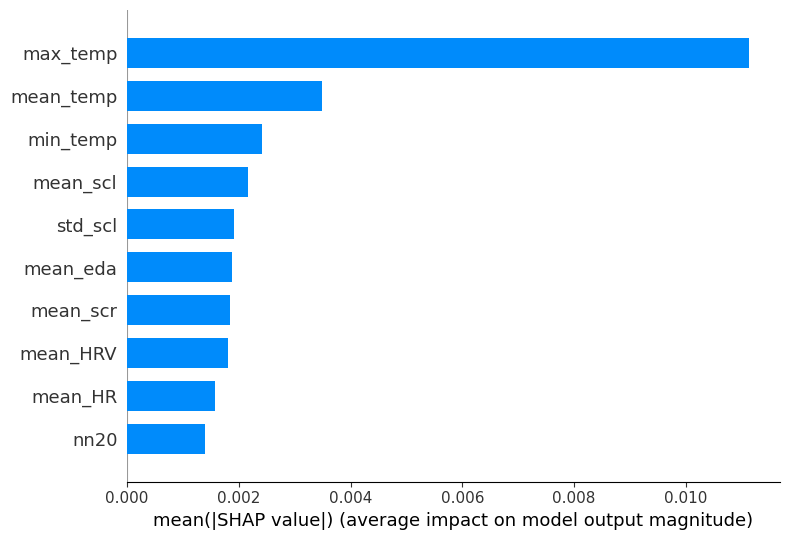

In [29]:
shap.summary_plot(shap_values[1], X_test_moments, plot_type="bar", max_display=10, feature_names=feature_names)

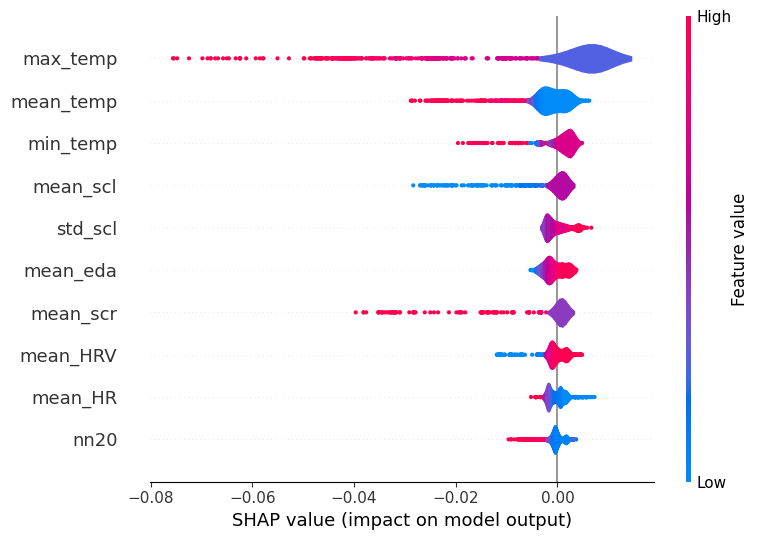

In [30]:
shap.summary_plot(shap_values[1], X_test_moments, plot_type="violin", max_display=10, feature_names=feature_names)

In [57]:
scaler = StandardScaler()
itw_lr_clf = LogisticRegression(
    random_state = 0,
    class_weight = 'balanced',
    n_jobs = -1,
    solver = 'saga',
    # C = 0.1,
    max_iter = 3000,
)
itw_lr_clf.fit(scaler.fit_transform(X_train), y_train)

LogisticRegression(class_weight='balanced', max_iter=3000, n_jobs=-1,
                   random_state=0, solver='saga')

In [24]:
y_pred_itw = itw_lr_clf.predict(scaler.transform(X_test))
print(Evaluator().evaluate(y_test, y_pred_itw))

{'accuracy': 0.6069952305246423, 'balanced_accuracy': 0.5306197127122012, 'precision': 0.20643549808992065, 'recall': 0.4108187134502924, 'f1': 0.27478975161353414}


In [25]:
y_pred_itw = itw_lr_clf.predict(scaler.transform(X_test_moments))
print(Evaluator().evaluate(y_test_moments, y_pred_itw))

{'accuracy': 0.6128177966101694, 'balanced_accuracy': 0.5438388446320631, 'precision': 0.21688500727802038, 'recall': 0.43567251461988304, 'f1': 0.28960155490767736}


In [ ]:
considered_features = feature_names.copy()
remove_features = []
THRESHOLD = 5
X = scaler.transform(X_train.copy())
while True:
    changed = False
    vif = pd.DataFrame()
    indices = [feature_names.index(f) for f in considered_features]
    _X = X[:, indices]
    vif["VIF Factor"] = [variance_inflation_factor(_X, i) for i in range(len(indices))]
    vif['features'] = considered_features
    f = vif.round(1).sort_values('VIF Factor', ascending=False).iloc[0]
    if f['VIF Factor'] > THRESHOLD:
        remove_features.append(f['features'])
        considered_features.remove(f['features'])
        changed = True
        print(f'Removing {f}')
    if changed == False:
        break

In [ ]:
indices = [feature_names.index(f) for f in considered_features]
X = scaler.transform(X_train.copy())
X = X[:, indices]
itw_lr_clf.fit(X, y_train)

In [ ]:
y_pred_itw = itw_lr_clf.predict(scaler.transform(X_test_moments)[:, indices])
print(Evaluator().evaluate(y_test_moments, y_pred_itw))

In [ ]:
explainer = shap.LinearExplainer(itw_lr_clf, X)
shap_values = explainer.shap_values(scaler.transform(X_test_moments)[:, indices])
shap.summary_plot(shap_values, scaler.transform(X_test_moments)[:, indices], plot_type="bar", max_display=10, feature_names=considered_features)

In [ ]:
shap.summary_plot(shap_values, scaler.transform(X_test_moments)[:, indices], plot_type="violin", max_display=10, feature_names=considered_features)

In [ ]:
all_moments = np.concatenate([X_train_moments, X_test_moments])
all_labels = np.concatenate([y_train_moments, y_test_moments])
y_preds_itw = itw_df_clf.predict(EmbeddingDataLoader(all_moments, all_labels))
print(Evaluator().evaluate(all_labels, y_preds_itw))
y_preds_itw = itw_et_clf.predict(all_moments)
print(Evaluator().evaluate(all_labels, y_preds_itw))
y_preds_itw = itw_lr_clf.predict(scaler.transform(all_moments))
print(Evaluator().evaluate(all_labels, y_preds_itw))